---
## Assumptions and rules
---

Use a simple, consistent backtest setup:
- Trade at **next day close** (i.e., use yesterday’s signal as today’s position)
- Ignore transaction costs and slippage (unless you choose to add them)
- Long/cash only for Part A
- Extensions may optionally include shorting, but it is not required

### What “backtest” means here
A backtest simulates how your portfolio would have performed historically if you had followed your trading rules mechanically.


In [ ]:
# Import your functions

---
# Part A: Core Task — Implement One Momentum Strategy
---




---
## Step 1: Libraries 
---

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs
import warnings

---
## Step 2: Load price data
---


In [4]:
# Prepare Apple data into a dataframe
def download_stock_data(ticker, start_date):
    data = yf.download(
        ticker,
        start=start_date,
        auto_adjust=True, #prices adjusted for dividends and splits
        progress=False
    )
    return data['Close'] 

# Download Apple data
prices = download_stock_data("AAPL", "2015-01-01") #close prices series indexed by date


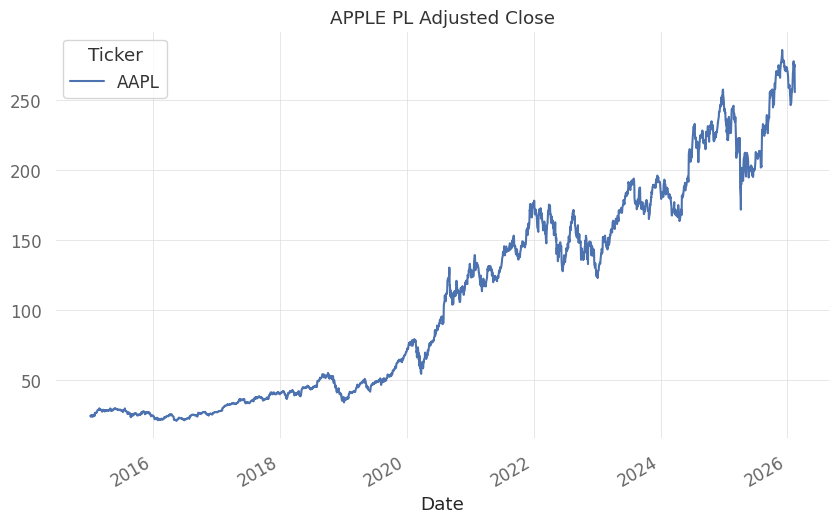

In [5]:
# Display the visualisation of the data
prices.plot(title="APPLE PL Adjusted Close")
plt.show()

---
## Step 2: Backtest framework
---

You will generate a `signal`:
- `1` = long
- `0` = cash

The backtest uses `position = signal.shift(1)` to avoid look-ahead bias.


In [ ]:
# Define the function which will develop

---
## Step 3: Implement one strategy
---




---
### Option A1: ROC Threshold
---

**Rule:** Buy if the price increased by more than a threshold over the last `roc_n` days.


In [ ]:
# Develop the ROC indicator

---
### Option A2: Moving Average Crossover
---

**Rule:** Buy when a fast moving average is above a slow moving average.


In [ ]:
# Develop the Moving Average Crossover indicator

---
### Option A3: MACD Signal
---

**Rule:** Buy when MACD is above its signal line.
- `MACD = EMA(12) - EMA(26)`
- `Signal line = EMA(9) of MACD`


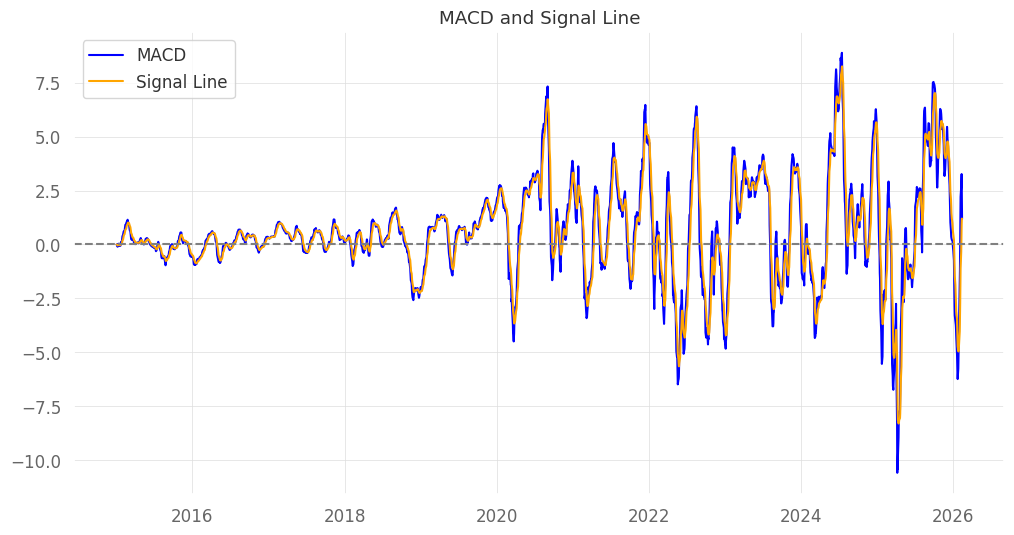

Bullish signals: Ticker
AAPL    100
dtype: int64
Bearish signals: Ticker
AAPL    101
dtype: int64


In [6]:
#Compute MACD 

def calculate_macd(prices, fast_span=12, slow_span=26, signal_span=9):
    # Calculate MACD components
    ema_fast = prices.ewm(span=fast_span, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_span, adjust=False).mean()
    macd_line = ema_fast - ema_slow

    # Smooth the MACD line to get the signal line and calculate the histogram
    signal_line = macd_line.ewm(span=signal_span, adjust=False).mean()
    histogram = macd_line - signal_line

    return macd_line, signal_line, histogram #returns one object as a tuple (ordered container of three objects) of three series: macd_line, signal_line, histogram

# Calculate MACD
macd, signal, histogram = calculate_macd(prices) # tuple unpacking, internally macd = calculate_macd(prices)[0], signal = calculate_macd(prices)[1], histogram = calculate_macd(prices)[2]

# Plot MACD and Signal line
plt.figure(figsize=(12, 6))
plt.plot(macd, label="MACD", color="blue")
plt.plot(signal, label="Signal Line", color="orange")

plt.axhline(0, color="gray", linestyle="--") # Add a horizontal line at y=0 for reference
plt.title("MACD and Signal Line")
plt.legend()
plt.show()

# Generate trading signals by shifting yesterday's MACD and Signal values to indicate crossovers
bullish_signals = ((macd > signal) & (macd.shift(1) <= signal.shift(1))).sum() # Count the number of times the MACD line crosses above the Signal line (bullish crossover) -> crossover due to macd.shift(1) and signal.shift(1) are used to compare the current values of macd and signal with their previous values to identify crossovers.
bearish_signals = ((macd < signal) & (macd.shift(1) >= signal.shift(1))).sum() # Count the number of times the MACD line crosses below the Signal line (bearish crossover)

print(f"Bullish signals: {bullish_signals}")
print(f"Bearish signals: {bearish_signals}")

#### **MACD visually captures volatility + trend strength, not just direction.**

- The blue line is MACD, which measures short term momentum relative to the longer term trend.

- The orange line is the signal line, a smoothed version of MACD that represents the recent average level of momentum.

- The dashed zero line separates bullish and bearish momentum regimes.

**Explanation**

- When MACD crosses above the signal line, momentum is strengthening upward, generating a bullish signal.

- When MACD crosses below the signal line, momentum is weakening, generating a bearish signal.

- Larger swings indicate stronger momentum or higher volatility, which is especially visible after 2020.

**Why it is useful**

- It filters noisy price movements into momentum signals.

- It helps time entries and exits by identifying momentum accelerations and reversals rather than predicting price levels.

#### **Backtest framework over past 10 years vs Buy-Hold Strategy**

ticker: AAPL
start: 2015-01-01
end: 2026-02-13
initial_capital: 1000000.000000
ending_value_strategy: 7056880.691632
ending_value_buyhold: 10562920.727201
profit_strategy: 6056880.691632
profit_pct_strategy: 6.056881
max_drawdown_strategy: -0.270335
trades: 199.000000
fee_rate_per_trade: 0.000500
strategy_name: macd_strategy
strategy_params: {'fast_span': 12, 'slow_span': 26, 'signal_span': 9}


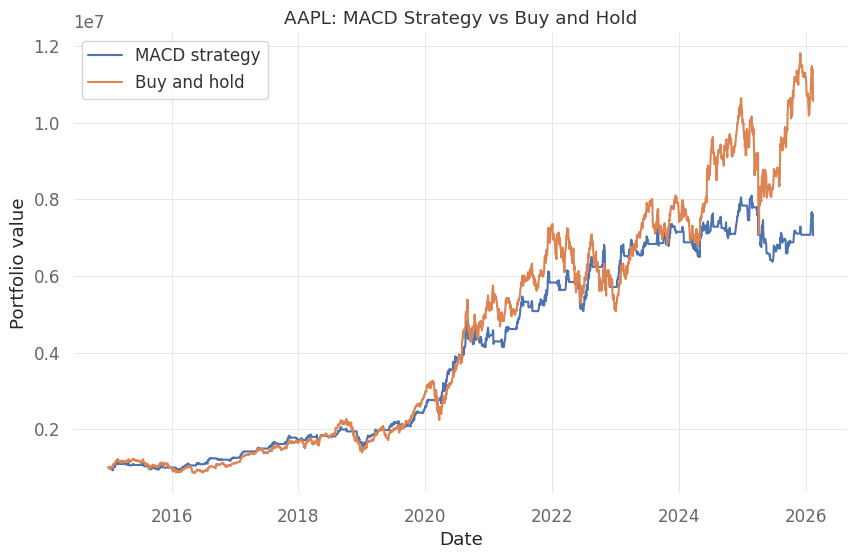

In [7]:
# 1) Import your backtest engine (edit the module name to match your file)
from backtest_function import run_backtest
import pandas as pd
import matplotlib.pyplot as plt


# 2) Define your MACD strategy function (returns RAW position, no shifting here)
def macd_strategy(prices: pd.Series, data: pd.DataFrame, params: dict) -> pd.Series:
    fast = int(params.get("fast_span", 12))
    slow = int(params.get("slow_span", 26))
    sig  = int(params.get("signal_span", 9))

    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()

    macd = ema_fast - ema_slow
    signal = macd.ewm(span=sig, adjust=False).mean()

    # long-only: 1 when MACD > signal else 0
    return (macd > signal).astype(float)

# 3) Run the backtest
res = run_backtest(
    ticker="AAPL",
    start="2015-01-01",
    strategy_fn=macd_strategy,
    strategy_params={"fast_span": 12, "slow_span": 26, "signal_span": 9},
    initial_capital=1_000_000.0,
    fee_rate_per_trade=0.0005,
    shift_signals_by=1,   # avoids look-ahead bias
    auto_adjust=True
)

# 4) Print results
for k, v in res.results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v}")

# 5) Plot equity curves
plt.figure()
plt.plot(res.equity_strategy, label="MACD strategy")
plt.plot(res.equity_buyhold, label="Buy and hold")
plt.title("AAPL: MACD Strategy vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.show()

#### **Reporting on graph**    

The orange line (buy and hold) grows faster in strong bull markets

The blue line (MACD) is smoother but **lags** badly when Apple trends strongly upward

Key visual insights:

*1) 2019–2021 bull market*

- Buy and hold explodes upward

- MACD repeatedly exits and re-enters

- This causes missed upside

*2)2022 market crash*

- Buy and hold falls hard

- MACD falls much less

*3) Post-2023 recovery*

- Buy and hold again dominates

- MACD stays cautious and under-participates

#### **COVID Period Analysis**

In [ ]:
# Analyze COVID period (2020-01-01 to 2021-12-01)
covid_start = "2020-01-01"
covid_end = "2021-12-01"

# Slice data for COVID period
px_covid = res.prices.loc[covid_start:covid_end]
pos_covid = res.position.reindex(px_covid.index).fillna(0).astype(int)

# Get entry and exit dates
changes = pos_covid.diff().fillna(0)
buy_dates = changes[changes == 1].index
sell_dates = changes[changes == -1].index

# Visualize
plt.figure()
plt.plot(px_covid.index, px_covid.values, label="AAPL price")
plt.scatter(buy_dates, px_covid.loc[buy_dates], marker="^", s=90, label="Buy", color='green')
plt.scatter(sell_dates, px_covid.loc[sell_dates], marker="v", s=90, label="Sell", color='red')
plt.title("AAPL price with MACD trades during COVID (01-2020 to 12-2021)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

#### **Final Quant (See File Named MACD Performance Report**

---
## Step 4: Backtest and report (Part A)
---

Run your backtest and report:
- Total return
- Number of trades
- Equity curve
- Price chart with buy/sell markers


In [ ]:
# Run the backtest amd report the results

---
## Part A short write-up
---

**Write 2–5 sentences:**
- What does your indicator measure?
- When does your strategy enter/exit?
- Why might this work (behavioural explanation)?

**Answer:**
- TODO

> **Checkpoint 3:** After completing the Part A strategy implementation and backtest, consider committing your notebook (e.g., "Finished Part A strategy").


---
# Part B: Extensions — Multiple Strategies and Composite Score
---

This section extends Part A by implementing multiple strategies and combining them into a composite score.


---
## Extension B1: Implement two additional strategies
---

Implement the **two strategies you did not choose** in Part A.

Use the provided functions to create signals for each new strategy. For example, if you chose ROC in Part A, you can use `signal_ma_crossover(...)` for one of the extensions and `signal_macd(...)` for the other. Ensure each strategy's signal is a 0/1 series like before, then backtest them just as in Part A.

### Deliverables
- Backtest each strategy under the same assumptions
- Produce a simple comparison table: total return, number of trades

> **Checkpoint 4:** Once you have completed a strategy, commit your progress (e.g., "Completed MA Crossover").


In [ ]:
# Complete the other strategy 1

In [ ]:
# Complete the other strategy 2

---
## Extension B2: Composite momentum score strategy
---

Build a composite score from ROC, MA crossover, and MACD.

### Requirements
- Convert each indicator into a **standardised sub-score** (e.g., -2..+2)
- Choose weights that sum to 1:
  $w_{roc} + w_{ma} + w_{macd} = 1$
- Composite score:
  $Score_t = w_{roc}s^{roc}_t + w_{ma}s^{ma}_t + w_{macd}s^{macd}_t$
- Trading rule (long/cash):
  - Long if `Score >= x`
  - Cash if `Score < x`

**Guidance:** First, convert each strategy's signal into a numerical sub-score on a common scale (we use -2 to +2 for ROC buckets, and -1/+1 for MA and MACD signals as given above). Next, assign weights to each component based on how much emphasis you want to give it. (If unsure, equal weights is a reasonable starting point.) Make sure the weights sum to 1. Then choose a threshold `x` for the composite score that determines when to go long. For example, `x = 0` would mean any positive composite signal triggers a long position, whereas a higher threshold (like 0.5) would require stronger agreement among indicators to enter a trade.


In [ ]:
# Complete the function which trades based on a composite score

---
## Extension B2 short write-up
---

**Write 4–8 sentences:**
- Why did you choose your weights and threshold `x`?
- Did the composite score outperform your best single strategy?
- What is one limitation of this backtest?

**Answer:**
- TODO

> **Checkpoint 5:** You have now completed the composite strategy implementation. Review your results and then make a final commit of the notebook (e.g., "Completed momentum strategies assignment").
